<center><h1>Midterm Project 3 (Solo)</h1></center>

I'd like you to pull together two big ideas we have looked at in the last several weeks: word embeddings and ANNs. And we will be working with a new dataset. A few words about it first.

#New Dataset: DonorsChoose.org

I got interested in this dataset because I actually donate through the DonorsChoose.org website. Every now and then I get a request from a Lane County K12 teacher/classroom for items they need to take on something they think is important for their students.

The way it works is that teachers from around the country put in proposals for funding. The proposals are non-trivial, involving 2 if not 3 essays. If a proposal is chosen, then it is put out for crowd-funding. And eventually I get an email :)

The organization behind the funding mechanism made a large part of their database of proposals available to the public (after anonymizing names). What they wanted the machine-learning community to help with was doing triage on proposals. They were getting so many that their human staff was overwhelmed.

I count us as part of the machine-learning community, so thought it would be fun to take on. The data is labeled as to whether it was accepted or rejected. And it is mostly text. Let's take a look.

In [0]:
import pandas as pd
url = 'https://www.dropbox.com/s/nvzheo8hjirwfmt/donate_uniform.csv?raw=1'
donate_table = pd.read_csv(url, encoding='utf-8')

In [0]:
len(donate_table)  #55468 proposals - it's a big one!

55468

In [0]:
donate_table.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p008074,977101b441d8624595f731b6bb25a3c9,Mrs.,WI,2016-09-23 15:10:36,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",An Easel for Early Learners,The learners in my class this year come from a...,This easel will provide a place to learn for y...,NaN,NaN,My students need an easel to use during carpet...,11,1
1,p043871,fa7f9115dd0344fbf613d13f1e6e7c33,Mrs.,CT,2016-08-01 15:05:58,Grades PreK-2,Health & Sports,"Gym & Fitness, Health & Wellness",Namaste-ing at School!,"I teach in a diverse science magnet school, wh...",These yoga materials will give my students the...,NaN,NaN,My students need an opportunity to unwind duri...,69,0
2,p028140,3b8c3e758318f86437efaccfe3f04ab8,Mrs.,PA,2017-03-24 12:54:34,Grades 6-8,Special Needs,Special Needs,Flexible Seating: Flexible Workplace,The typical school chairs just aren't comforta...,"As adults in the workplace, we have some flexi...",NaN,NaN,My students need to build the skills necessary...,1,0
3,p155310,1d286ff10ee3982b2b47813f1e415ef2,Ms.,CA,2016-08-26 00:08:16,Grades 3-5,Literacy & Language,"Literacy, Literature & Writing",Captivating Readers with Graphic Nonfiction,Can I keep reading? Please? I really don't wan...,My students love independent reading time beca...,NaN,NaN,My students need history and biography graphic...,50,1
4,p137236,4024d231df51084915d024965640602c,Mrs.,CO,2017-01-07 18:38:51,Grades 3-5,Math & Science,Mathematics,Mrs. Smith's Sharp Students Seeking Support!,We are a fun loving group of 8 and 9 year olds...,We would like to use these Kindles to help us ...,NaN,NaN,My students need more technology to help with ...,0,1


You can see the text fields: `project_grade_category,	project_subject_categories,	project_subject_subcategories,	project_title,	project_essay_1,	project_essay_2,	project_essay_3,	project_essay_4,	project_resource_summary`. All of the proposals have all of these fields with the exception of the 3rd and 4th essay. Some proposals are missing those.

Before going too much further, let's bring in the libraries we will need.

##puddles



In [0]:
#flush the old directory
!rm -r  'uo_puddles'

In [0]:
my_github_name = 'uo-puddles'  #replace with your account name

In [0]:
#clone_url = f'https://github.com/{my_github_name}/w20_ds_library.git'
clone_url = f'https://github.com/{my_github_name}/uo_puddles.git'

In [0]:
#get the latest.
!git clone $clone_url 


Cloning into 'uo_puddles'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 258 (delta 154), reused 64 (delta 33), pack-reused 0
Receiving objects: 100% (258/258), 66.97 KiB | 806.00 KiB/s, done.
Resolving deltas: 100% (154/154), done.


In [0]:
import uo_puddles.uo_puddles as up

Make sure you see your part A functions from below listing.

##Bring in spacy pieces

In [0]:
import spacy

In [0]:
!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import en_core_web_md
nlp = en_core_web_md.load()  

##sent2vec

You are going to end up needing to call sent2vec. So you need to copy it below along with the functions it relies on. This is from Chapter 7.

BTW: if you built your own library you could place these in it. Then just import them as opposed to copying and pasting. Just sayin.

In [0]:
#copy and paste

### Vector Math ###
def addv(x:list, y:list) -> list:
  assert isinstance(x, list), f"x must be a list but instead is {type(x)}"
  assert isinstance(y, list), f"y must be a list but instead is {type(y)}"
  assert len(x) == len(y), f"x and y must be the same length"

  result = [(c1+c2) for c1, c2 in zip(x,y)]
  return result

def dividev(x:list, y:int) -> list:
  assert isinstance(x, list), f"x must be a list but instead is {type(x)}"
  assert isinstance(y, int), f"y must be a list but instead is {type(y)}"

  result = [c/y for c in x]
  return result

def meanv(matrix:list) -> list:
  assert isinstance(matrix, list), f"x must be a list but instead is {type(x)}"
  assert len(matrix) >= 1, f"matrix must have at least one row"

  sumv = matrix[0]
  for row in matrix[1:]:
    sumv = addv(sumv,row)
  result = dividev(sumv, len(matrix))

  return result


### Get GloVe vector for a single string/word ### 
def get_vec(s:str) -> list:
    return nlp.vocab[s].vector.tolist()

### Get the mean GloVe vector for a single sentence ###
def sent2vec(sentence) -> list:
  assert isinstance(sentence, str), f'sentence is not a str but instead a {type(sentence)}'

  doc = nlp(sentence.lower())
  sentence_vectors = []
  for token in doc:
    if token.is_alpha and not token.is_stop:
      sentence_vectors.append(get_vec(token.text))
  
  if len(sentence_vectors) < 1:
    sentence_average = [0.0]*300
  else:
    sentence_average = meanv(sentence_vectors)

  return sentence_average

In [0]:
#test
svect = sent2vec('Now is the time.')

In [0]:
print(svect[:10])  #[0.17242999374866486, 0.2750200033187866, 0.05086300149559975, -0.1960500031709671, -0.23851999640464783, 0.040334999561309814, -0.12639999389648438, -0.20701000094413757, 0.08738300204277039, 2.734999895095825]

[0.17242999374866486, 0.2750200033187866, 0.05086300149559975, -0.1960500031709671, -0.23851999640464783, 0.040334999561309814, -0.12639999389648438, -0.20701000094413757, 0.08738300204277039, 2.734999895095825]


In [0]:
funky_vector = sent2vec('the the the')  #all stop words

In [0]:
funky_vector.count(0)  #300

300

##Holdout

First shuffle the table getting ready to split into train and test sets.

In [0]:
import numpy as np
rsgen = np.random.RandomState(1234)  #use this so we get same values

In [0]:
shuffled_table = donate_table.sample(frac=1, random_state=rsgen).reset_index(drop=True)

In [0]:
shuffled_table.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p122443,613ac392781124be92aecc0d8b251c43,Mrs.,WI,2017-04-01 13:53:57,Grades PreK-2,"Literacy & Language, Applied Learning","Literacy, Parent Involvement",Building Their Own Library,Students come into school eager to learn and e...,My students need books to take home and build ...,NaN,NaN,My students need books to build their own pers...,57,1
1,p103593,2698dc172679d7164ee43f959cecda84,Mr.,CA,2017-01-12 02:26:10,Grades PreK-2,"Literacy & Language, Applied Learning","Literature & Writing, Parent Involvement",Seeing Is Believing,I have been blessed with 25 amazing kindergart...,"All day long, I have the great opportunity to ...",NaN,NaN,My students need these items to make their vid...,1,0
2,p250727,df7f28a1d5bd6a69e9c42cc91cdbc74d,Ms.,GA,2016-06-30 09:11:22,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",iRead with an iPad,This year I will be working with 14 students i...,The addition of this iPad to our classrooms wi...,NaN,NaN,My students need an iPad and protective case t...,13,1
3,p016256,9792d0650db1f7c1e7419c3d77cc4afd,Mr.,GA,2016-09-16 10:26:53,Grades PreK-2,Applied Learning,"College & Career Prep, Early Development",Chromebook's For Learning,My students are super excited about using tech...,The need for more devices in my classroom is a...,NaN,NaN,My students need these laptops to integrate mo...,2,1
4,p009182,07139002c47bb9dd9e50cc8e4fc233ba,Mrs.,MD,2016-09-07 14:50:50,Grades 6-8,Music & The Arts,"Music, Performing Arts",Music to My Ears! A Highlandtown Music Project...,My students are beginning and intermediate ban...,There are many elements to a successful music ...,NaN,NaN,My students need basic supplies to supplement ...,1,1


##It's too big

It took me 1 hour just to find the meanv for all 55468 rows. My worry that this will also show up even more pronounced when we start doing ANN training. So I am going to trim the table to one that is more practical for this project. In real life and on your job, you should tell your boss that working with this smaller dataset should still give you results in the right ballpark. And it will be the truth. I ran on full dataset so can attest to it.

In [0]:
project_table = shuffled_table[:1000]  #grab first one thousand rows as our working table

##Big choice now: which column(s)?

I'll tell you that I played with all of them. And I would ask you to do the same if we had more time. So I tried these alone: `title, essay1, essay2, summary`. I also tried all of them joined together as one long string. Using `sent2vec`, the summary column, alone, was a good tradeoff between accuracy and compute time. So that is what we will go with. If you were being paid to tackle this problem, then you should do a more thorough exploration than I did.

Here is an example summary.

In [0]:
project_table.loc[0, 'project_resource_summary']

'My students need books to build their own personal library at home.'

##You know my drill by now

Pull things out of pandas for efficiency.

In [0]:
summaries = project_table['project_resource_summary'].tolist()

In [0]:
labels = project_table['project_is_approved'].tolist()

#Assignment 1
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Go ahead and create a matrix of all the summaries in `summaries`. Call sent2vec on each summary to get a 300 element vector and add that vector onto your matrix. Call your matrix `summary_vectors`.

Took me about 9 seconds so our trim-down seems to have paid off.

In [0]:
%%time

#your code
summary_vectors = []

for i in range(len(summaries)):
  sentence = summaries[i]
  vec = sent2vec(sentence)
  summary_vectors.append(vec)


CPU times: user 9.5 s, sys: 2.66 ms, total: 9.5 s
Wall time: 9.54 s


In [0]:
len(summary_vectors)

1000

In [0]:
for i in range(3):
  print(summary_vectors[i][:10])

[0.08351857561085906, -0.01547499852521079, -0.06052000394889286, 0.058037854598036835, 0.0949410703365824, 0.1183599978685379, -0.05477571434208325, -0.15380999871662684, 0.14014585688710213, 2.5372428723743985]
[0.0071530017469610485, 0.015338572008269174, -0.12791514343449048, 0.017434429244271347, 0.019168556834171926, -0.10338238360626358, -0.20135443391544477, -0.010731421411037445, 0.09900685559426035, 2.5181571585791453]
[-0.10876393256088097, 0.13409386180962127, -0.020134333396951358, 0.0664909990504384, -0.13508276763993005, -0.14518782396335156, -0.11277958997525275, 0.06626373368004958, -0.041377002745866774, 2.008830012877782]


<pre>
[0.08351857561085906, -0.01547499852521079, -0.06052000394889286, 0.058037854598036835, 0.0949410703365824, 0.1183599978685379, -0.05477571434208325, -0.15380999871662684, 0.14014585688710213, 2.5372428723743985]
[0.0071530017469610485, 0.015338572008269174, -0.12791514343449048, 0.017434429244271347, 0.019168556834171926, -0.10338238360626358, -0.20135443391544477, -0.010731421411037445, 0.09900685559426035, 2.5181571585791453]
[-0.10876393256088097, 0.13409386180962127, -0.020134333396951358, 0.0664909990504384, -0.13508276763993005, -0.14518782396335156, -0.11277958997525275, 0.06626373368004958, -0.041377002745866774, 2.008830012877782]
</pre>

##Finally, do the split

I'll use first .7 for training and last .3 for testing.

In [0]:
X_train = summary_vectors[:700]
Y_train = labels[:700]
print(Y_train[:20])  #[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]


In [0]:
X_test = summary_vectors[700:]
Y_test = labels[700:]
print(Y_test[:20])  #[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]

[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]


##What we need to beat

We can get this score just by always guessing 1 in the test set.

In [0]:
Y_test.count(1)/len(Y_test)  #0.5076666666666667 (do you mean .50333333?)

0.5033333333333333

So it looks like roughly half the proposals are accepted in this dataset.

#Part 1 of the project

I would like you to see for yourselves why I have been harping on overfitting and the need for using something like the holdout method. We can see the problem fairly starkly with the data we have.

#Assignment 2
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Set up a network with with 4 layers as such: `[128,64,32,1]`.

In [0]:
m = up.ann_build_model(300,[128,64,32,1])

Now train it with 300 epochs. 3.5 minutes for me.

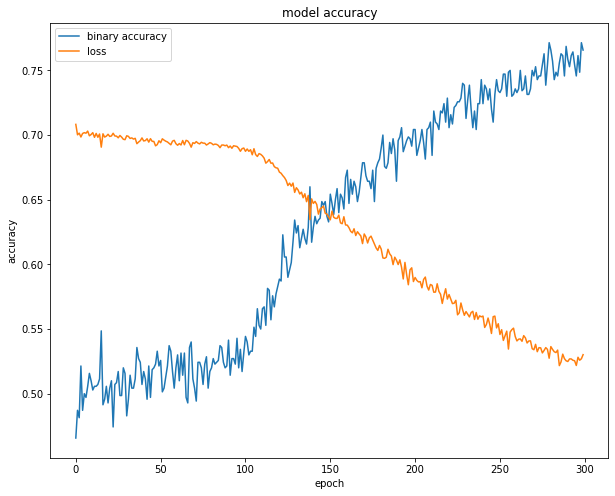

CPU times: user 4min 18s, sys: 20.4 s, total: 4min 39s
Wall time: 3min 39s


In [0]:
%%time
#300 epochs
training = up.ann_train(m, X_train, Y_train, 300)

<img src='https://www.dropbox.com/s/euz6e2j4llw2ga1/Screenshot%202020-05-23%2008.40.54.png?raw=1' height=100>

In [0]:
training.history['binary_accuracy'][-10:]

[0.758571445941925,
 0.7528571486473083,
 0.7614285945892334,
 0.7642857432365417,
 0.7542856931686401,
 0.7457143068313599,
 0.7614285945892334,
 0.7485714554786682,
 0.7714285850524902,
 0.7657142877578735]

In [0]:
training.history['binary_accuracy'][-10:]

[0.758571445941925,
 0.7528571486473083,
 0.7614285945892334,
 0.7642857432365417,
 0.7542856931686401,
 0.7457143068313599,
 0.7614285945892334,
 0.7485714554786682,
 0.7714285850524902,
 0.7657142877578735]

You can see the last accuracy computed was `.7657`.

Now get accuracy from the test set. You should see .59.

In [0]:
# calculate predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  #.59 with 300 epochs

0.59

#Assignment 3
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

I don't usually do this, but I would like your (written) thoughts on what you surmise looking at the graph, history and testing results above. Why should you continue adding epochs? Or alternatively, why would you say best we can do with this architecture so time to look at other architectures?

I'll give you a blank text box below. Double-click it to open and write in it.

***I believe that we should continue adding epochs because the error of our model is still at about 50%, which could still be reduced. However, I also believe accuracy on the test set is still relatively low (59%), which might be made worse by continuing to train a model more attuned to our training sample. I think the sweet spot would be running it once more with a few hundred epochs (matter of minutes) to see if we can reduce the error. If not, it might help to adjust the model.***

#Assignment 4
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Rightly or wrongly, I am going to push on.
I am going to ask you to try another 300. You can copy your code from above (do not include the `up.ann_create_model` cell). Another 3 minutes for me.



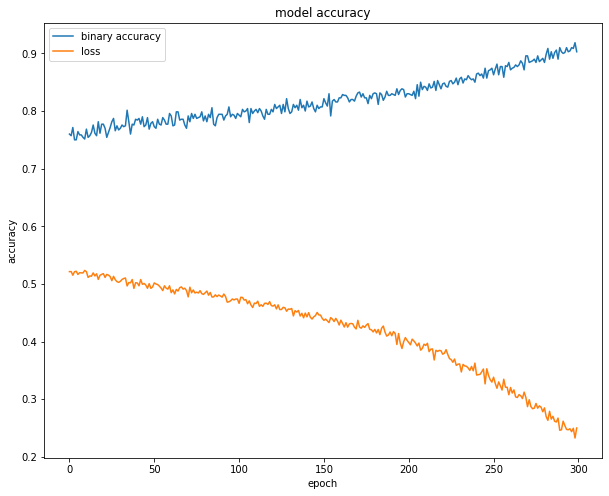

CPU times: user 4min 25s, sys: 20.6 s, total: 4min 45s
Wall time: 3min 40s


In [0]:
%%time

training = up.ann_train(m, X_train, Y_train, 300)


<img src='https://www.dropbox.com/s/n4kvkbcl5j0p6xb/Screenshot%202020-05-23%2008.43.40.png?raw=1' height=100>

In [0]:
training.history['binary_accuracy'][-10:]  #last accuracy:  0.9028571248054504

[0.9028571248054504,
 0.8999999761581421,
 0.9014285802841187,
 0.9100000262260437,
 0.9028571248054504,
 0.904285728931427,
 0.9100000262260437,
 0.9085714221000671,
 0.918571412563324,
 0.9028571248054504]

In [0]:
# calculate predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  #.55

0.55

#Assignment 5
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Your written observations now. Continue or shift architectures? Use text box below.

**I think it would be best to try building a model that will better generalize to the test set.**

#Assignment 6
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

One more time. Add another 200 epochs on. Copy and paste code from above and make sure the edit to make it 200 and not 300.

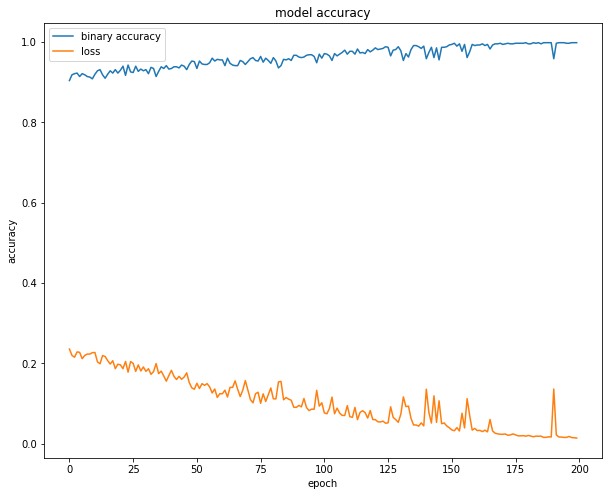

CPU times: user 2min 55s, sys: 13.5 s, total: 3min 9s
Wall time: 2min 26s


In [0]:
%%time

training = up.ann_train(m, X_train, Y_train, 200)

<img src='https://www.dropbox.com/s/75ygm6j2zd6bdwb/Screenshot%202020-05-23%2008.45.49.png?raw=1' height=100>

In [0]:
training.history['binary_accuracy'][-10:]  #last accuracy: 0.9985714554786682

[0.9585714340209961,
 0.9971428513526917,
 0.9985714554786682,
 0.9985714554786682,
 0.9985714554786682,
 0.9971428513526917,
 0.9971428513526917,
 0.9985714554786682,
 0.9985714554786682,
 0.9985714554786682]

In [0]:
# calculate predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  #0.5266666666666666

0.5233333333333333

#I rest my case :)

What happened you ask? Maybe you know. We overfitted on the training data. We got really good, in fact nearly perfect, at predicting on the training data. Do you doubt we could get to 1.0 with a few more epochs? You shouldn't. We could.

Meantime, our testing accuracy continues to fall. Look up the need for holdout in the dictionary, and you will see this example. Without it, we would have turned over a perfect model to our boss. Which would fail miserably as new proposals come in. We would be demoted to the most thankless data science job. What would that be? Writing nested loops forever? Or worse, maybe writing R code. Just kidding! Mostly.

#Part 2

I hope I have made a good case for need for holdout. Next thing I want to take up is the pain of copying-and-pasting all that code above. I claim that using an ANN, or really any machine-learning model, is an exploration process. But I am not giving you anything beyond copy-and-paste to support that idea. Until now!

##Grid-Search

I want to introduce you to a new concept. The jargony name is *grid-search*. It is set up to help you manage exploration of the hyperparameters of an ANN. It's not too complicated. You give it  (a) the set of hyperparameters you want to explore, and (b) what alternative values you want to try for each, and grid-search does the rest. And gives you a  summary of what worked best. Nice, huh.

##Cross-Validation

Grid-search makes use of one new concept that we need to dicuss: *cross-validation*. Guess what cross-validation is used for? What does our job rest on? Avoiding overfitting! So cross-validation is yet another mechanism to avoid over-fitting. It basically says, hey, why wait until the very end of training to run your test set? I can help you test while you are training.

What cross-validation does is do 3 separate holdouts on your training data. It divides your training (not testing) set into 3 equal segments, call them s1, s2, s3. It trains your model first with s1+s2 and tests with s3. Then trains your model with s1+s3 and tests with s2. Finally it trains your model with s2+s3 and tests with s1. It gives you the average test accuracy of the 3 separate trials. This is all during training. We still do testing to get the gold standard accuracy.

I'll do a small trial just to get you used to seeing how it works. I'll try 2 different architectures and 4 different epoch values. You will see I will get 2x4x3 different training examples: 2x4 from my alternatives then times 3 for the 3 separate cross-validation cases.

Read this code as follows:
<pre>
up.grid_search([[64,10,1], [32,1]]], [10,15,20,30], X_train, Y_train)
</pre>
* `up.grid_search` is the puddles function that will do the exploration using a cross-validation of 3.

* `[[64,10,1], [32,1]]`. A list of architecture alternatives. First alternative tries `[64,10,1]` and second `[32,1]`.

* `[10,15,20,30]`. Try 10, 15, 20 and 30 epochs separately.

* `X_train, Y_train`. The training data.

In [0]:
up.grid_search([[64,10,1], [32,1]], [10,15,20,30], X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1) ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1), total=   5.3s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1) ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1), total=   5.2s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1) ........
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 10, 1), total=   5.2s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   4.9s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   4.9s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   4.7s
[CV] batch_size=1, epochs=15, input_dim=300, lyrs=(64, 10, 1) ........
[CV]  batch_size=1, epochs=15, input_dim=300, lyrs=(64, 10, 1), total=   7.3s
[CV] batch_size=1, epochs=15, input_dim=300, lyrs=(64, 10, 1) ........
[CV]  batch_size=1, epochs=15, input_dim=300, lyrs=(64, 10, 1), total=   7.6s
[CV] batch_size=1, epochs=15, input_dim=

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.6min finished


Best: 0.592911 using {'batch_size': 1, 'epochs': 20, 'input_dim': 300, 'lyrs': (32, 1)}
0.511427 (0.010559) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (64, 10, 1)}
0.560025 (0.035465) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (32, 1)}
0.537178 (0.042220) with: {'batch_size': 1, 'epochs': 15, 'input_dim': 300, 'lyrs': (64, 10, 1)}
0.560006 (0.007683) with: {'batch_size': 1, 'epochs': 15, 'input_dim': 300, 'lyrs': (32, 1)}
0.535765 (0.049070) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 300, 'lyrs': (64, 10, 1)}
0.592911 (0.027829) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 300, 'lyrs': (32, 1)}
0.534268 (0.022875) with: {'batch_size': 1, 'epochs': 30, 'input_dim': 300, 'lyrs': (64, 10, 1)}
0.555715 (0.033291) with: {'batch_size': 1, 'epochs': 30, 'input_dim': 300, 'lyrs': (32, 1)}


You can see each of the 8 cases and how long it took. But here is the interesting piece:
<pre>
Best: 0.592911 using {'batch_size': 1, 'epochs': 20, 'lyrs': (32, 1)}
0.511427 (0.010559) with: {'batch_size': 1, 'epochs': 10, 'lyrs': (64, 10, 1)}
0.560025 (0.035465) with: {'batch_size': 1, 'epochs': 10, 'lyrs': (32, 1)}
0.537178 (0.042220) with: {'batch_size': 1, 'epochs': 15, 'lyrs': (64, 10, 1)}
0.560006 (0.007683) with: {'batch_size': 1, 'epochs': 15, 'lyrs': (32, 1)}
0.535765 (0.049070) with: {'batch_size': 1, 'epochs': 20, 'lyrs': (64, 10, 1)}
0.592911 (0.027829) with: {'batch_size': 1, 'epochs': 20, 'lyrs': (32, 1)}
0.534268 (0.022875) with: {'batch_size': 1, 'epochs': 30, 'lyrs': (64, 10, 1)}
0.555715 (0.033291) with: {'batch_size': 1, 'epochs': 30, 'lyrs': (32, 1)}
</pre>
This `0.511427 (0.010559)` says that when looking at `'epochs': 10, 'lyrs': (64, 10, 1)` and running the 3 cross-validation steps and taking the average, we got 0.511427 as the mean of those 3 steps and (0.010559) as the standard deviation.

Looking at the results, I can see that 20 epochs with only 2 layers performed the best out of the 8 cases. On the training set! We can now run it for real and then test. Let's do that.

In [0]:
m = up.ann_build_model(300, [32,1])  #choosing the winning architecture

Now train it with 20 epochs. Couple seconds for me.

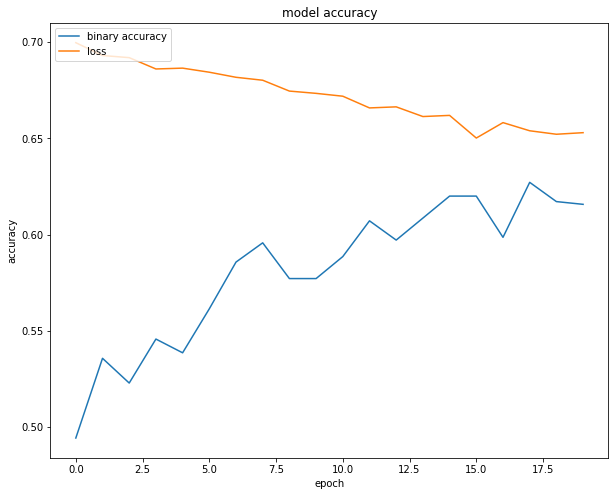

CPU times: user 15.8 s, sys: 1.28 s, total: 17.1 s
Wall time: 13.3 s


In [0]:
%%time
#20 epochs
training = up.ann_train(m, X_train, Y_train, 20)  #and the winning epochs

<img src='https://www.dropbox.com/s/sbjyerwvdpzxeyu/Screenshot%202020-05-23%2009.01.58.png?raw=1' height=100>

In [0]:
training.history['binary_accuracy'][-10:]  #last:  0.6157143115997314

[0.5885714292526245,
 0.6071428656578064,
 0.5971428751945496,
 0.6085714101791382,
 0.6200000047683716,
 0.6200000047683716,
 0.5985714197158813,
 0.6271428465843201,
 0.6171428561210632,
 0.6157143115997314]

In [0]:
# calculate predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  #0.5866666666666667

0.5866666666666667

I think this is pretty interesting. Just looking at our plot, it looks like we have a long way to go to push the loss down. And we do! But the cross-validation accuracy we are getting is much closer to the testing accuracy. My conjecture is that cross-validation is giving us a more realistic view, during training, of the result we will likely see in testing.

You can try it out if you want, but I went ahead and tried with more epochs and guess what. The loss did go down. And the training accuracy did go up. But the testing accuracy  got worse, so heading in the wrong direction (i.e., overfitting).

#Assignment 7
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

I'd like you to use your intuition to find an architecture and epoch combo that beats .59 with testing.

To get your first intuition, you might try grid_search with a large number of alternatives. And then go get a snack while it runs. This should point you to the right ballpark. I would then do another grid_search with more refined alternatives.

Remember to check things out with the winning combo on the test set after each grid-search. It is the actual focus. Trying to get it past .59.

In [0]:
#your exploration
up.grid_search([[16,8,1], [8,1], [4,1], [16,1]], [25,50,100], X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1) .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1), total=  12.1s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1) .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1), total=  12.4s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1) .........
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(16, 8, 1), total=  12.1s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1) .............
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1), total=  11.3s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1) .............
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1), total=  11.5s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1) .............
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(8, 1), total=  11.2s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(4, 1) .............
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(4, 1), total=  11.2s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(4, 1) .............
[CV]  batch_size=1, epochs=25, input_dim=300, lyrs=(4, 1), total=  11.4s
[CV] batch_size=1, epochs=25, input_dim=300, lyrs=(4, 1

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 15.9min finished


Best: 0.587213 using {'batch_size': 1, 'epochs': 25, 'input_dim': 300, 'lyrs': (8, 1)}
0.494259 (0.030954) with: {'batch_size': 1, 'epochs': 25, 'input_dim': 300, 'lyrs': (16, 8, 1)}
0.587213 (0.041318) with: {'batch_size': 1, 'epochs': 25, 'input_dim': 300, 'lyrs': (8, 1)}
0.587188 (0.037250) with: {'batch_size': 1, 'epochs': 25, 'input_dim': 300, 'lyrs': (4, 1)}
0.585727 (0.020254) with: {'batch_size': 1, 'epochs': 25, 'input_dim': 300, 'lyrs': (16, 1)}
0.564298 (0.026999) with: {'batch_size': 1, 'epochs': 50, 'input_dim': 300, 'lyrs': (16, 8, 1)}
0.572857 (0.008762) with: {'batch_size': 1, 'epochs': 50, 'input_dim': 300, 'lyrs': (8, 1)}
0.581411 (0.016612) with: {'batch_size': 1, 'epochs': 50, 'input_dim': 300, 'lyrs': (4, 1)}
0.555715 (0.022778) with: {'batch_size': 1, 'epochs': 50, 'input_dim': 300, 'lyrs': (16, 1)}
0.551447 (0.009828) with: {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (16, 8, 1)}
0.537153 (0.006203) with: {'batch_size': 1, 'epochs': 100, 'input_dim'

In [0]:
up.grid_search([[16,1], [8,1], [4,1]], [150,200,250], X_train, Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1) ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1) ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1) ...........
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(16, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(8, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(4, 1) ............
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(4, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(4, 1) ............
[CV]  batch_size=1, epochs=150, input_dim=300, lyrs=(4, 1), total= 1.1min
[CV] batch_size=1, epochs=150, input_dim=300, lyrs=(4,

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 40.5min finished


Best: 0.531461 using {'batch_size': 1, 'epochs': 150, 'input_dim': 300, 'lyrs': (4, 1)}
0.528606 (0.032893) with: {'batch_size': 1, 'epochs': 150, 'input_dim': 300, 'lyrs': (16, 1)}
0.527194 (0.046093) with: {'batch_size': 1, 'epochs': 150, 'input_dim': 300, 'lyrs': (8, 1)}
0.531461 (0.030875) with: {'batch_size': 1, 'epochs': 150, 'input_dim': 300, 'lyrs': (4, 1)}
0.510063 (0.039759) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (16, 1)}
0.517210 (0.036150) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (8, 1)}
0.524357 (0.041134) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (4, 1)}
0.505784 (0.045434) with: {'batch_size': 1, 'epochs': 250, 'input_dim': 300, 'lyrs': (16, 1)}
0.512912 (0.041688) with: {'batch_size': 1, 'epochs': 250, 'input_dim': 300, 'lyrs': (8, 1)}
0.515780 (0.041650) with: {'batch_size': 1, 'epochs': 250, 'input_dim': 300, 'lyrs': (4, 1)}


In [0]:
up.grid_search([[64,32,16,8,4,1]], [20,50,100,200,400], X_train, Y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  11.7s
[CV] batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s


[CV]  batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  11.6s
[CV] batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=20, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  11.7s
[CV] batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  28.1s
[CV] batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  28.2s
[CV] batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=50, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  28.6s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1), total=  56.4s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(64, 32, 16, 8, 4, 1) 
[CV]  batch_size=1, epochs=100,

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 21.5min finished


Best: 0.522872 using {'batch_size': 1, 'epochs': 20, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}
0.522872 (0.022194) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}
0.521441 (0.023579) with: {'batch_size': 1, 'epochs': 50, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}
0.487106 (0.029145) with: {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}
0.522872 (0.022194) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}
0.522872 (0.022194) with: {'batch_size': 1, 'epochs': 400, 'input_dim': 300, 'lyrs': (64, 32, 16, 8, 4, 1)}


In [0]:
up.grid_search([[8,4,1],[8,1],[4,1]], [100,200,400], X_train, Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1) .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1), total=  48.1s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1) .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.1s remaining:    0.0s


[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1), total=  47.8s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1) .........
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 4, 1), total=  47.7s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1), total=  45.3s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1), total=  46.0s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1) ............
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(8, 1), total=  46.0s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(4, 1) ............
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(4, 1), total=  46.2s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs=(4, 1) ............
[CV]  batch_size=1, epochs=100, input_dim=300, lyrs=(4, 1), total=  45.3s
[CV] batch_size=1, epochs=100, input_dim=300, lyrs

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 48.1min finished


Best: 0.572894 using {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (8, 4, 1)}
0.572894 (0.022033) with: {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (8, 4, 1)}
0.537153 (0.006203) with: {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (8, 1)}
0.537129 (0.009896) with: {'batch_size': 1, 'epochs': 100, 'input_dim': 300, 'lyrs': (4, 1)}
0.504335 (0.028899) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (8, 4, 1)}
0.517210 (0.036150) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (8, 1)}
0.524357 (0.041134) with: {'batch_size': 1, 'epochs': 200, 'input_dim': 300, 'lyrs': (4, 1)}
0.514349 (0.031495) with: {'batch_size': 1, 'epochs': 400, 'input_dim': 300, 'lyrs': (8, 4, 1)}
0.498649 (0.046474) with: {'batch_size': 1, 'epochs': 400, 'input_dim': 300, 'lyrs': (8, 1)}
0.525769 (0.027287) with: {'batch_size': 1, 'epochs': 400, 'input_dim': 300, 'lyrs': (4, 1)}


In [0]:
m = up.ann_build_model(300,[8,1])

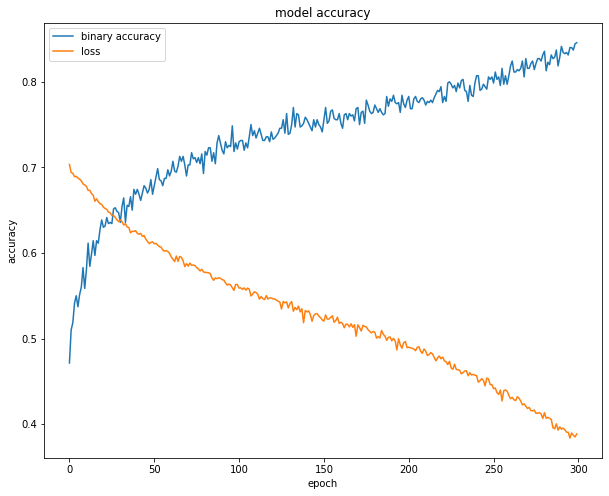

In [0]:
training = up.ann_train(m, X_train, Y_train, 300)

In [0]:
training.history['binary_accuracy'][-10:]

[0.8414285778999329,
 0.8342857360839844,
 0.8328571319580078,
 0.8342857360839844,
 0.831428587436676,
 0.8399999737739563,
 0.8399999737739563,
 0.8371428847312927,
 0.8442857265472412,
 0.845714271068573]

In [0]:
# calculate predictions
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)  

0.6

##Important caveat

You may not find anything that beats .59. That's ok as long as I see you gave it the old college try.